In [1]:
import pandas as pd
import miniball
import matplotlib.pyplot as plt
import math
import random
import numpy as np



from sklearn.metrics import classification_report, confusion_matrix
# import faiss

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats

import permutation_test as p

/u/nlp/anaconda/main/anaconda3/envs/katezhou/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Section 3: Rich Countries Have Tokens

In [2]:
countries_data = pd.read_csv("country_metadata/un_countries_meta.csv")
countries_data['name'] = countries_data['Name'].apply(lambda x: x.lower())

In [3]:
print("Number of multiword countries", len(countries_data[countries_data['Name'].str.contains(" ")]))
print("Number of single word countries", len(countries_data[~countries_data['Name'].str.contains(" ")]))
print("Number of in-vocabulary countries", len(countries_data[countries_data['subpieces']==1]))


Number of multiword countries 34
Number of single word countries 159
Number of in-vocabulary countries 134


In [4]:
#Get an example of subpiece tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenizer("Andorra")

NameError: name 'BertTokenizer' is not defined

In [ ]:
#gather examples of names by subpieces
display(countries_data[countries_data['subpieces'] < 4].groupby('subpieces').mean())
display(countries_data[countries_data['subpieces'] >= 4].mean(axis=0))

In [ ]:
countries_data[countries_data['Name'].isin(set(['Uzbekistan', 'Comoros', 'Grenada', 'Eswatini']))]


In [ ]:
for features in [['freq_logged']]:
    Y = countries_data[['subpieces']].values
    X = countries_data[features].values
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    print(results.summary(xname=['Constant'] + features, yname='Radius'))

In [ ]:
#calculate correlation between frequency and gdp
stats.pearsonr(x=countries_data['freq'].values, y=countries_data['gdp'].values)

# Geometric Impact

In [ ]:
def process_embeddings(word_embeddings):
    word_embeddings = word_embeddings.reset_index()
    #getting rid sentence embeddings
    word_embeddings = word_embeddings[list(range(0, 768)) + [1537, 1538]]
    #lower casing names
    word_embeddings[1537] = word_embeddings[1537].apply(lambda x: x.lower())
    word_embeddings['tokens'] = word_embeddings[1538]
    return word_embeddings

In [ ]:
#read in embeddings data
first_embeddings = process_embeddings(pd.read_csv("embeddings/country_names_first_embeddings.csv", header=None))
average_embeddings = process_embeddings(pd.read_csv("embeddings/country_names_average_embeddings.csv", header=None))



In [ ]:
def calculate_norms(word_embeddings):
    word_embeddings['norm'] = np.sqrt(np.square(word_embeddings[range(0, 768)]).sum(axis=1))
    word_embeddings = word_embeddings.groupby(1537).mean()
    word_embeddings = word_embeddings.reset_index()

    word_embeddings = word_embeddings.set_index(1537).join(countries_data.set_index('name'), how='inner')

    Y = word_embeddings[['norm']].values
    X = word_embeddings[['subpieces']].values

    plt.figure(figsize=(6, 3))
    plt.scatter(X,Y,s=10,color="#377eb8")
    plt.xlabel("# of Subwords", fontsize=20)
    plt.ylabel("Norm of Vector", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title("# of Subwords vs norm",fontsize=20)
    plt.savefig("figures/norm_vs_subpieces_first.pdf", bbox_inches='tight', dpi=600)
    print(word_embeddings[['norm','subpieces']].corr("pearson"))


calculate_norms(first_embeddings)
calculate_norms(average_embeddings)

# Richer countries are most distinct in embedding space

In [6]:
from fastdist import fastdist
def calculate_cosine_similarity(word_embeddings, keyword_index=1537):
    result = pd.DataFrame()
    for n, row_n in word_embeddings.iterrows():
        temp = []
        temp.append(row_n[keyword_index])
        current_row = row_n[:768]
        for m, row_m in word_embeddings.iterrows():
            if(n == m):
                temp.append(0)
                continue
                #just itself
            other_row = row_m[:768]
            similarity = fastdist.cosine(list(np.array(current_row)), list(np.array(other_row)))
            temp.append(similarity)
        print(n)
        result = result.append([temp])
#         print(row_n[768])
    result.columns = ['Name'] + list(word_embeddings[keyword_index].values)
    return result

ModuleNotFoundError: No module named 'numba'

In [ ]:
def calculate_cosine_similarity_helper(word_embeddings, output_filename):
    for x in range(0, 10):
        print(x)
        cosine_sample = word_embeddings.groupby(1537).apply(lambda x: x.sample(n=1)).reset_index(drop=True)
        cosine_result = calculate_cosine_similarity(cosine_sample)
        cosine_result.to_csv("cosine_results/" + output_filename + str(x) + ".csv")

In [ ]:
#These results can be found in the folder "cosine_results"

# calculate_cosine_similarity_helper(first_embeddings, 'cosine_result')
# calculate_cosine_similarity_helper(average_embeddings, 'cosine_result_average')

In [7]:
def calculate_ingroup_similarity_frequency(df):

    ingroup_sample = df.copy()
    ingroup_sample = ingroup_sample.set_index('Name').join(countries_data.set_index("name"), how='outer')

    #Calculate similarity for in-vocabularly words
    ingroup_sample = ingroup_sample[ingroup_sample['subpieces']==1]
    #Calculate Frequency
    ingroup_sample['freq_quantile'] = pd.qcut(ingroup_sample['freq_logged'], q=10, precision=3)
    intervals = list(ingroup_sample['freq_quantile'].unique().categories.left) + list(ingroup_sample['freq_quantile'].unique().categories.right)[-1:]

    #Take the most frequent and least frequent categores
    most_frequent = ingroup_sample[ingroup_sample['freq_logged'] <= intervals[1]]
    least_frequent = ingroup_sample[ingroup_sample['freq_logged'] >= intervals[-2]]
    
    #Mean of upper triangle
    most_frequent = most_frequent.where(np.triu(np.ones(most_frequent.shape)).astype(bool))
    most_frequent = most_frequent[list(most_frequent.index)]
    most_frequent = most_frequent.mean(axis=1).mean()

    least_frequent = least_frequent.where(np.triu(np.ones(least_frequent.shape)).astype(bool))
    least_frequent = least_frequent[list(least_frequent.index)]
    least_frequent = least_frequent.mean(axis=1).mean()
    return most_frequent, least_frequent

In [8]:
cosine_result = pd.DataFrame()
most_frequent_in_group_similarity = []
least_frequent_in_group_similarity = []

for x in range(0, 10):
    temp = pd.read_csv("cosine_results/cosine_result_average" + str(x) + ".csv")
    most_frequent, least_frequent = calculate_ingroup_similarity_frequency(temp)
    most_frequent_in_group_similarity.append(most_frequent)
    least_frequent_in_group_similarity.append(least_frequent)
    cosine_result = pd.concat([cosine_result, temp.drop('Name', axis=1)], axis=1)
    
cosine_result['Name'] = temp['Name']
cosine_result = cosine_result.drop("Unnamed: 0", axis=1)
cosine_result = cosine_result.replace(0, bool("nan"))

cosine_result['avg'] = cosine_result[cosine_result.columns[0:-1]].mean(axis=1)

cosine_result = cosine_result.set_index('Name').join(countries_data.set_index("name"), how='outer')
cosine_result = cosine_result.dropna(subset=['gdp'])

cosine_result['freq_quantile'] = pd.qcut(cosine_result['freq_logged'], q=10, precision=3)
cosine_result['gdp_quantile'] = pd.qcut(cosine_result['gdp_logged'], q=10, precision=3)

print(np.array(most_frequent_in_group_similarity).mean(), np.array(least_frequent_in_group_similarity).mean())

0.61043441567908 0.5824171253909559


In [9]:
p.permutationtest(most_frequent_in_group_similarity, least_frequent_in_group_similarity)

taking random subsample of size 20000 from 184756 possible permutations
nr of mean diffs: 20000


 Distribution of mean differences
                                       │                                        
                                     * ┼+33.489                                 
                                  * * ****                                      
                                *      │  *                                     
                                 *     │   ** *                                 
                               *       │       *                                
                              *        │        *                               
                            **         │         **                             
                                       │                                        
                         * *           │           **                           
                        *              │                  

/u/nlp/anaconda/main/anaconda3/envs/katezhou/lib/python3.8/site-packages/permutation_test/functions.py:240: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  freq, bin_edges = np.histogram(data\


0.005249999999998312

In [10]:
#OLS for similarity and countries
temp = cosine_result[cosine_result['subpieces']==1]

for features in [['freq_logged']]:
    Y = temp[['avg']].values
    X = temp[features].values
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    print(results.summary(xname=['Constant'] + features, yname='Radius'))

    

                            OLS Regression Results                            
Dep. Variable:                 Radius   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     12.13
Date:                Mon, 09 May 2022   Prob (F-statistic):           0.000675
Time:                        11:05:39   Log-Likelihood:                 330.73
No. Observations:                 134   AIC:                            -657.5
Df Residuals:                     132   BIC:                            -651.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Constant        0.6989      0.019     37.386      

In [11]:
print("Number of countries with over a 0.7 similarity with 'France'(averaged over 10 trials): ", (cosine_result[['france']] >= 0.7).sum().sum()/10)
print("Number of countries with over a 0.7 similarity with 'Haiti'(averaged over 10 trials): ", (cosine_result[['haiti']] >= 0.7).sum().sum()/10)


Number of countries with over a 0.7 similarity with 'France'(averaged over 10 trials):  21.2
Number of countries with over a 0.7 similarity with 'Haiti'(averaged over 10 trials):  59.3


/tmp/ipykernel_4139576/2910881878.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['in_vocabulary'] = temp['Name'].apply(lambda x: 1 if (x in ['Germany', "Botswana"]) else 0)


                avg  gdp_logged
avg         1.00000    -0.28164
gdp_logged -0.28164     1.00000


<Figure size 720x360 with 0 Axes>

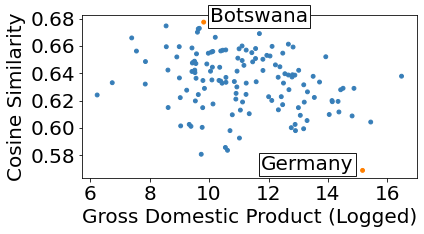

In [12]:
#Visualize Cosine Similarity Results
temp = cosine_result[cosine_result['subpieces']==1]
X = temp[['gdp_logged']].values
Y = temp[['avg']].values

plt.figure(figsize=(10, 5))
temp['in_vocabulary'] = temp['Name'].apply(lambda x: 1 if (x in ['Germany', "Botswana"]) else 0)
categories = np.array(temp['in_vocabulary'].values)

colormap = np.array(['#377eb8', '#ff7f00'])

plt.figure(figsize=(6, 3))
plt.scatter(X,Y, s=15, c=colormap[categories])

from numpy.polynomial.polynomial import polyfit
# # Fit with polyfit
b, m = polyfit(list(temp['gdp_logged'].values), list(temp['avg'].values), 1)
# plt.plot(list(temp['gdp_logged'].values), b + m * temp['gdp_logged'].values, '-')

plt.xlabel("Gross Domestic Product (Logged)", fontsize=20)
plt.ylabel("Cosine Similarity", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20, label=0.4)

n = list(temp['Name'].values)


for i, txt in enumerate(n):
    if (txt in set(['Germany', "Botswana"])):
        if (txt=='Germany'):
            plt.annotate(txt, (X[i]-.3, Y[i]), fontsize=20, ha='right', bbox=dict(facecolor='1', edgecolor='.1', pad=2.0))
        else:
            plt.annotate(txt, (X[i]+.2, Y[i]), fontsize=20, ha='left', bbox=dict(facecolor='1', edgecolor='.1', pad=2.0))

plt.savefig("figures/gdp_cosine.pdf", bbox_inches='tight', dpi=600)
print(temp[['avg', 'gdp_logged']].corr("pearson"))


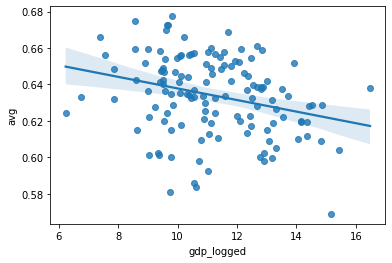

In [13]:
import seaborn as sns
ax = sns.regplot(x=temp['gdp_logged'], y=temp['avg'], data=temp)

# Artificial Context

In [ ]:
# # Cosine similarity artificial context
# for x in range(0, 20):
#     print(x)
#     cosine_sample = a_embeddings[a_embeddings[1536]==x]
#     cosine_result = calculate_cosine_similarity(cosine_sample)
#     cosine_result.to_csv("cosine_results/artificial_context_average_embeddings_" + str(x) + ".csv")


In [35]:
cosine_result = pd.DataFrame()
for x in range(10, 20):
    temp = pd.read_csv("cosine_results/artificial_context_average_embeddings_" + str(x) + ".csv")
    cosine_result = pd.concat([cosine_result, temp.drop('Name', axis=1)], axis=1)
    
cosine_result.columns = [x.lower() for x in cosine_result.columns]
cosine_result['Name'] = [x.lower() for x in temp['Name']]
cosine_result = cosine_result.drop("unnamed: 0", axis=1)
cosine_result = cosine_result.replace(0, np.NaN)

cosine_result['avg'] = cosine_result[cosine_result.columns[0:-1]].mean(axis=1)

cosine_result = cosine_result.set_index('Name').join(countries_data.set_index("name"), how='outer')
cosine_result = cosine_result.dropna(subset=['gdp'])

cosine_result['freq_quantile'] = pd.qcut(cosine_result['freq_logged'], q=10, precision=3)
cosine_result['gdp_quantile'] = pd.qcut(cosine_result['gdp_logged'], q=10, precision=3)

In [36]:
#OLS for similarity and countries
temp = cosine_result[cosine_result['subpieces']==1]

for features in [['freq_logged']]:
    Y = temp[['avg']].values
    X = temp[features].values
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    print(results.summary(xname=['Constant'] + features, yname='Radius'))

    

                            OLS Regression Results                            
Dep. Variable:                 Radius   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     12.47
Date:                Fri, 18 Mar 2022   Prob (F-statistic):           0.000570
Time:                        14:16:57   Log-Likelihood:                 440.48
No. Observations:                 134   AIC:                            -877.0
Df Residuals:                     132   BIC:                            -871.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Constant        0.8458      0.008    102.629      

# Tokenization’s effect on semantic similarity.

In [93]:
def calculate_ingroup_similarity_by_token(df):
    ingroup_sample = df.copy()

    ingroup_sample = ingroup_sample.set_index('Name').join(countries_data.set_index("name"), how='outer')

    in_vocab = ingroup_sample[ingroup_sample['subpieces'] == 1]
    oov = ingroup_sample[ingroup_sample['subpieces'] >= 2]
    
    #create upper triangle
    in_vocab = in_vocab.where(np.triu(np.ones(in_vocab.shape)).astype(bool))
    #keep only in-vocabularly words
    in_vocab = in_vocab[list(in_vocab.index)]
    #calculate the average across all in-vocabularly pairs
    in_vocab = in_vocab.mean(axis=1).mean()

    #create upper triangle
    oov = oov.where(np.triu(np.ones(oov.shape)).astype(bool))
    #keep only in-vocabularly words
    oov = oov[list(oov.index)]
    #calculate the average across all in-vocabularly pairs
    oov = oov.mean(axis=1).mean()
    return in_vocab, oov

In [85]:
def read_cosine_results_tokens(filename):
    in_vocab_in_group_similarity = []
    out_of_vocab_in_group_similarity = []

    for x in range(0, 10):
        df = pd.read_csv(filename + str(x) + ".csv")

        in_vocab, oov = calculate_ingroup_similarity_by_token(df)
        in_vocab_in_group_similarity.append(in_vocab)
        out_of_vocab_in_group_similarity.append(oov)
    
    return cosine_result, in_vocab_in_group_similarity, out_of_vocab_in_group_similarity

In [86]:
# cosine_result, in_vocab_in_group_similarity, out_of_vocab_in_group_similarity = read_cosine_results("cosine_results/cosine_result")
cosine_result, in_vocab_in_group_similarity, out_of_vocab_in_group_similarity = read_cosine_results("cosine_results/cosine_result_average")
print(np.array(in_vocab_in_group_similarity).mean(), np.array(out_of_vocab_in_group_similarity).mean())


0.6277066577793942 0.6676263368341808


In [87]:
p.permutationtest(in_vocab_in_group_similarity, out_of_vocab_in_group_similarity)

taking random subsample of size 20000 from 184756 possible permutations
nr of mean diffs: 20000


 Distribution of mean differences
                                        │                                       
                                      * ┼+39.5815                               
                                    ** *│**                                     
                                        │  *                                    
                                   *    │   ***                                 
                                 **     │      **                               
                                *       │                                       
                              *         │                                       
                             *          │        **                             
                            *           │           *                           
                           *            │            *    

/u/nlp/anaconda/main/anaconda3/envs/katezhou/lib/python3.8/site-packages/permutation_test/functions.py:240: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  freq, bin_edges = np.histogram(data\


0